Some useful imports.

In [17]:
import numpy as np
try:
    import sionna
except ImportError as e:
    import os
    os.system("pip install sionna")
    import sionna
import tensorflow as tf
from utils import CDMA_encode, CDMA_decode, random_data, PlusMinusOne2Binary, Rayleigh_canal, Binary2String, String2Binary
import matplotlib.pyplot as plt
from scipy.special import erfc

class bcolors:
    OK = "\033[92m"  # GREEN
    WARNING = "\033[93m"  # YELLOW
    FAIL = "\033[91m"  # RED
    RESET = "\033[0m"  # RESET COLOR

Input data and used parameters.

In [18]:
tx_params = {
    "nUsers" : 4,
    "powerAllocation_dB" : 0,
    "nMessage" : 6,
    "cCode" : 3,
    "correctorRate" : 1/2,
    "nCodeCDMA" : 8,
    "symb_freq" : 25e3,
    "codes" : []
}

data_preview = random_data(tx_params)
data_out_preview = CDMA_encode(data_preview, tx_params)
data_estimated_preview = CDMA_decode(data_out_preview , tx_params)
for i in range(tx_params["nUsers"]):
    data_preview [i] = PlusMinusOne2Binary(data_preview [i], int)

print_preview = False
if print_preview:
    print("We want to transmit the following data to "+str(tx_params["nUsers"])+" users.")
    print(data_preview)
    print("Therefore we encode via CDMA and we get the following no-noise channel.")
    print(data_out_preview)
    print("Finally this is the estimated transmitted data from the CDMA decoder.")
    print(data_estimated_preview)

    if((data_estimated_preview ==data_preview ).all()) : 
        print(bcolors.OK + "Well Done !" + bcolors.RESET)
    else : 
        print(bcolors.WARNING + "Try Again..." + bcolors.RESET)

Use sionna to create a scenario and a channel expression. 

In [19]:
nmodbits = 2
binary_source = sionna.utils.BinarySource()
channel = sionna.channel.AWGN()

# constellation = sionna.mapping.Constellation("qam", nmodbits)
# mapper = sionna.mapping.Mapper(constellation=constellation)
# demapper = sionna.mapping.Demapper("app", "qam", nmodbits, hard_out=True, dtype=tf.complex128)

Compute nice metrics in the cell below.

In [20]:
ebn0 = np.arange(0, 21, 1)
snr_db = ebn0 + 10*np.log10(tx_params["correctorRate"]) + 10*np.log10(nmodbits)
nb_seq = 1000
alpha = 0
ber_OnlyCode = np.zeros(len(ebn0))
ber_ChannelNoise = np.zeros(len(ebn0))
ber_ZeroForcing = np.zeros(len(ebn0))

for i in range(len(snr_db)) :

  ber_OnlyCode_i = np.zeros(nb_seq)
  ber_ChannelNoise_i = np.zeros(nb_seq)
  ber_ZeroForcing_i = np.zeros(nb_seq)
  var_noise = 1/(10**(0.1*snr_db[i]))

  for j in range(nb_seq) :

    BinarySource = binary_source([tx_params["nUsers"], tx_params["nMessage"]])
    BinarySource = BinarySource.numpy()

    # Il manquerait pas un truc qui prendrait en compte le codingRate, le mapping et le power?
    # Map = mapper(Coding)
    # data = Map.numpy()

    data = BinarySource
    data_channel = CDMA_encode(data, tx_params)
    
    h = Rayleigh_canal(alpha, len(data_channel))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape) 
         + np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape))
    channel = data_channel*h + n
    zero_forcing = channel/h

    decoded_OnlyCode = CDMA_decode(data_channel, tx_params)
    decoded_ChannelNoise = CDMA_decode(channel, tx_params)
    decoded_ZeroForcing = CDMA_decode(zero_forcing, tx_params)
    
    decoded_tf_OnlyCode = tf.convert_to_tensor(decoded_OnlyCode)
    decoded_tf_ChannelNoise = tf.convert_to_tensor(decoded_ChannelNoise)
    decoded_tf_ZeroForcing = tf.convert_to_tensor(decoded_ZeroForcing)
    
    BinarySource = tf.cast(tf.less(0.0, BinarySource), tf.float32)
    decoded_tf_OnlyCode = tf.cast(tf.less(0.0, decoded_tf_OnlyCode), tf.float32)
    decoded_tf_ChannelNoise = tf.cast(tf.less(0.0, decoded_tf_ChannelNoise), tf.float32)
    decoded_tf_ZeroForcing = tf.cast(tf.less(0.0, decoded_tf_ZeroForcing), tf.float32)
    
    ber_OnlyCode_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_OnlyCode)
    ber_ChannelNoise_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_ChannelNoise)
    ber_ZeroForcing_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_ZeroForcing)

    ber_OnlyCode_i[j] = ber_OnlyCode_j.numpy()
    ber_ChannelNoise_i[j] = ber_ChannelNoise_j.numpy()
    ber_ZeroForcing_i[j] = ber_ZeroForcing_j.numpy()

  ber_OnlyCode[i] = np.mean(ber_OnlyCode_i)
  ber_ChannelNoise[i] = np.mean(ber_ChannelNoise_i)
  ber_ZeroForcing[i] = np.mean(ber_ZeroForcing_i)

  print_plots = False
  if print_plots:
      if (i==3)or(i==10)or(i==14)or(i==19):
        plt.figure()
        plt.scatter(np.real(channel), np.imag(channel))
        plt.axline((0,0),(0,1))
        plt.axline((0,0),(1,0))
        plt.show()

  print("Eb/N0 = " + str(ebn0[i]) + ", " + " "*(i<10) + bcolors.OK + "BER_OnlyCode = " + str(ber_OnlyCode[i]) + bcolors.RESET + ", " 
        + bcolors.FAIL + "BER_ChannelNoise = " + f"{ber_ChannelNoise[i]:.9f}" + bcolors.RESET + ", " # str(ber_ChannelNoise[i]) 
        + bcolors.WARNING + "BER_ZeroForcing = " + f"{ber_ZeroForcing[i]:.9f}" + bcolors.RESET) # str(ber_ZeroForcing[i])

Eb/N0 = 0,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.499208333, BER_ZeroForcing = 0.020250000
Eb/N0 = 1,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.490291667, BER_ZeroForcing = 0.016583333
Eb/N0 = 2,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.502708333, BER_ZeroForcing = 0.010041667
Eb/N0 = 3,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.499541667, BER_ZeroForcing = 0.009416667
Eb/N0 = 4,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.500416667, BER_ZeroForcing = 0.006166667
Eb/N0 = 5,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.507125000, BER_ZeroForcing = 0.005125000
Eb/N0 = 6,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.506791667, BER_ZeroForcing = 0.004958333
Eb/N0 = 7,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.494666667, BER_ZeroForcing = 0.004000000
Eb/N0 = 8,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.503500000, BER_ZeroForcing = 0.002708333
Eb/N0 = 9,  BER_OnlyCode = 0.0, BER_ChannelNoise = 0.493666667, BER_ZeroForcing = 0.002416667
Eb/N0 = 10, BER_OnlyCode = 0.0, BER_ChannelNoise = 0.4912500

Let's plot some cool stuff. Beginning with the BER(SNR) curve.

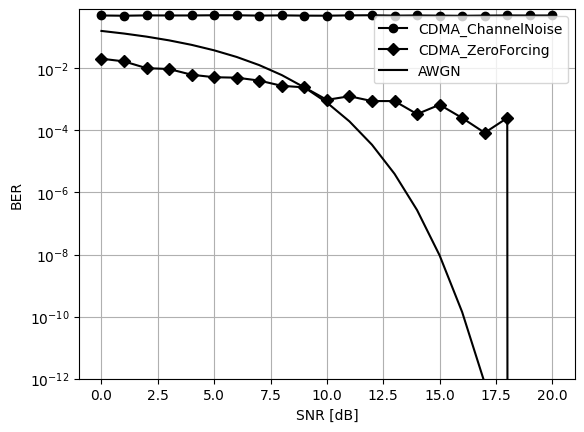

In [21]:
plt.figure()
# plt.semilogy(snr_db, ber_OnlyCode, "V-", label="CDMA_OnlyCode", color="black")
plt.semilogy(snr_db, ber_ChannelNoise, "o-", label="CDMA_ChannelNoise", color="black")
plt.semilogy(snr_db, ber_ZeroForcing, "D-", label="CDMA_ZeroForcing", color="black")
ber_awgn = (1/2)*erfc(np.sqrt(10**(0.1*snr_db)/2))
plt.plot(snr_db, ber_awgn, label="AWGN", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.ylim([10**(-12), 0.8])
plt.show()

Let's also try something crazy. Try the system with real string words.

In [24]:
nmodbits = 2
channel = sionna.channel.AWGN()
message = "Hello World!"
data_message = String2Binary(message, tx_params)

ebn0 = np.arange(0, 21, 1)
snr_db = ebn0 + 10*np.log10(tx_params["correctorRate"]) + 10*np.log10(nmodbits)

message_OnlyCode = ['']*tx_params["nUsers"]
message_ChannelNoise = ['']*tx_params["nUsers"]
message_ZeroForcing = ['']*tx_params["nUsers"]

for i in range(len(ebn0)) :
  data_channel = CDMA_encode(data_message, tx_params)
    
  h = Rayleigh_canal(0, len(data_channel))
  var_noise = 1/(10**(0.1*snr_db[i]))
  n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape) 
       + np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape))
  channel = data_channel*h + n
  zero_forcing = channel/h
    
  decoded_OnlyCode = CDMA_decode(data_channel, tx_params)
  decoded_ChannelNoise = CDMA_decode(channel, tx_params)
  decoded_ZeroForcing = CDMA_decode(zero_forcing, tx_params)

  for j in range(tx_params["nUsers"]):
    message_OnlyCode[j] = Binary2String(decoded_OnlyCode[j])
    message_ChannelNoise[j] = Binary2String(decoded_ChannelNoise[j])
    message_ZeroForcing[j] = Binary2String(decoded_ZeroForcing[j])

  print("SNR [dB] = " + str(i))
  print('')
  print("OnlyCode" + "     : " + str(message_OnlyCode))
  print("ChannelNoise : " + str(message_ChannelNoise))
  print("ZeroForcing" + "  : " + str(message_ZeroForcing))
  print('----------------------------------------------')
  print('')

TypeError: String2Binary() takes 1 positional argument but 2 were given

Now that we have done something fun, it's time to compute a bit of outage probability.

In [ ]:
# HERE OUTAGE PROBABILITY